In [1]:
import os
import torch
import torch.nn as nn


from config import get_config
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.resume import fill_trackers_from_history
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy


In [2]:
# cfg=get_config(config_path="config/mamba_vision_bs512_ep50_lr1e-04_ds1000.yml")
cfg=get_config(config_path="config/efficientnet_bs512_ep50_lr1e-01_ds1000.yml")
# cfg=get_config()
print(cfg)

[INFO] Config Path: config/efficientnet_bs512_ep50_lr1e-01_ds1000.yml
[INFO] Detected native Ubuntu host: DS044955
[INFO] Using dataset root: /home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Detected dataset size: 1000
namespace(model_tag='EfficientNet', backbone='efficientnet', batch_size=512, epochs=50, learning_rate=0.1, patience=10, input_shape=(1, 32, 32), global_max=121.79151153564453, dataset_root_dir='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled', train_csv='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled/file_labels_train.csv', val_csv='/home/arsalan/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_be

In [3]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1


In [4]:
# Set seed, device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")
# torch.backends.cudnn.benchmark = True

[INFO] Using device: cuda


In [5]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 2
[INFO] Length of validation dataloader: 1
[INFO] Length of test dataloader: 1


In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

MultiHeadClassifier(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (con

In [7]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)


/home/arsalan/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = torch.nn.DataParallel(model)
else:
    print("Using single GPU")
    

Using single GPU


In [9]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [10]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [11]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics,summary_status = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1/training_summary.json


In [12]:
fill_trackers_from_history(
    all_epoch_metrics,
    train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list,
    train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list,
    val_loss_energy_list, val_loss_alpha_list, val_loss_q0_list, val_loss_list,
    val_acc_energy_list, val_acc_alpha_list, val_acc_q0_list, val_acc_list,
    summary_status, best_epoch
)

In [ ]:
# for testing
# train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
# print(f"[INFO] Training metrics: {train_metrics}")

In [13]:
for epoch in range(start_epoch, cfg.epochs):
    print(f"[INFO] Epoch {epoch+1}/{cfg.epochs}")
    train_metrics={}
    train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
    (train_loss_list,
    train_loss_energy_list,
    train_loss_alpha_list,
    train_loss_q0_list,
    train_acc_list,
    train_acc_energy_list,
    train_acc_alpha_list,
    train_acc_q0_list
    ) = update_train_logs(
        train_metrics,
        train_loss_list,
        train_loss_energy_list,
        train_loss_alpha_list,
        train_loss_q0_list,
        train_acc_list,
        train_acc_energy_list,
        train_acc_alpha_list,
        train_acc_q0_list
    )
    val_metrics = evaluate(val_loader, model, criterion, device)
    (val_loss_list,
    val_loss_energy_list,
    val_loss_alpha_list,
    val_loss_q0_list,
    val_acc_list,
    val_acc_energy_list,
    val_acc_alpha_list,
    val_acc_q0_list,
    ) = update_val_logs(
        val_metrics,
        val_loss_list,
        val_loss_energy_list,
        val_loss_alpha_list,
        val_loss_q0_list,
        val_acc_list,
        val_acc_energy_list,
        val_acc_alpha_list,
        val_acc_q0_list,
    )
    print(f"[INFO] Epoch {epoch+1}: Energy Acc ={val_metrics['energy']['accuracy']:.4f}, αs Acc = {val_metrics['alpha']['accuracy']:.4f}, Q0 Acc = {val_metrics['q0']['accuracy']:.4f}, Total Acc = {val_metrics['accuracy']:.4f}")
    print(f"[INFO] Epoch {epoch+1}: Energy Loss ={val_metrics['loss_energy']:.4f}, αs Loss = {val_metrics['loss_alpha']:.4f}, Q0 Loss = {val_metrics['loss_q0']:.4f}, Total Loss = {val_metrics['loss']:.4f}")
    
    scheduler.step(val_metrics['accuracy'])  # or macro average accuracy if defined
    for param_group in optimizer.param_groups:
        current_lr = param_group['lr']
        print(f"📉 Current LR: {current_lr}")
    
    all_epoch_metrics=record_and_save_epoch(epoch, train_metrics, val_metrics, current_lr, all_epoch_metrics, cfg.output_dir)
    
    # save_epoch_checkpoint(
    #     epoch=epoch,
    #     model=model,
    #     optimizer=optimizer,
    #     metrics=val_metrics,
    #     output_dir=cfg.output_dir
    # )

    best_acc, best_metrics, best_epoch, early_stop_counter, should_stop = check_early_stopping(
        best_acc=best_acc,
        best_metrics=best_metrics,
        early_stop_counter=early_stop_counter,
        best_epoch=best_epoch,
        model=model,
        optimizer=optimizer,
        val_metrics=val_metrics,
        output_dir=cfg.output_dir,
        patience=cfg.patience,
        epoch=epoch
    )
    
    if should_stop:
        break
    
    print("="*150)
    

[INFO] Epoch 1/50


[INFO] Epoch 1: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 1: Energy Loss =3576060.5000, αs Loss = 9680855.0000, Q0 Loss = 16736949.0000, Total Loss = 29993864.0000
📉 Current LR: 0.1
[INFO] Epoch 1: Saving metrics to disk
💾 Last model saved at epoch 1
⏳ No improvement. Early stop counter: 1/10
[INFO] Epoch 2/50


[INFO] Epoch 2: Energy Acc =0.2500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 2: Energy Loss =218813472.0000, αs Loss = 378492768.0000, Q0 Loss = 385061024.0000, Total Loss = 982367232.0000
📉 Current LR: 0.1
[INFO] Epoch 2: Saving metrics to disk


💾 Last model saved at epoch 2
⏳ No improvement. Early stop counter: 2/10
[INFO] Epoch 3/50


[INFO] Epoch 3: Energy Acc =0.2500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 3: Energy Loss =8130244.0000, αs Loss = 40359016.0000, Q0 Loss = 58977664.0000, Total Loss = 107466928.0000
📉 Current LR: 0.1
[INFO] Epoch 3: Saving metrics to disk


💾 Last model saved at epoch 3
⏳ No improvement. Early stop counter: 3/10
[INFO] Epoch 4/50


[INFO] Epoch 4: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 4: Energy Loss =717473.1875, αs Loss = 1796677.8750, Q0 Loss = 1816272.3750, Total Loss = 4330423.5000
📉 Current LR: 0.1
[INFO] Epoch 4: Saving metrics to disk


💾 Last model saved at epoch 4
✅ Best model saved at epoch 4 with total accuracy: 0.0833
[INFO] Epoch 5/50


[INFO] Epoch 5: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 5: Energy Loss =102660.9844, αs Loss = 81989.9141, Q0 Loss = 154967.5469, Total Loss = 339618.4375
📉 Current LR: 0.1
[INFO] Epoch 5: Saving metrics to disk


💾 Last model saved at epoch 5
⏳ No improvement. Early stop counter: 1/10
[INFO] Epoch 6/50


[INFO] Epoch 6: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 6: Energy Loss =39793.4336, αs Loss = 23223.7559, Q0 Loss = 70545.7266, Total Loss = 133562.9062
📉 Current LR: 0.1
[INFO] Epoch 6: Saving metrics to disk


💾 Last model saved at epoch 6
⏳ No improvement. Early stop counter: 2/10
[INFO] Epoch 7/50


[INFO] Epoch 7: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 7: Energy Loss =35667.8555, αs Loss = 28771.2676, Q0 Loss = 57328.2656, Total Loss = 121767.3906
📉 Current LR: 0.1
[INFO] Epoch 7: Saving metrics to disk


💾 Last model saved at epoch 7
⏳ No improvement. Early stop counter: 3/10
[INFO] Epoch 8/50


[INFO] Epoch 8: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 8: Energy Loss =11555.7568, αs Loss = 4323.9409, Q0 Loss = 21864.7754, Total Loss = 37744.4727
📉 Current LR: 0.05
[INFO] Epoch 8: Saving metrics to disk
💾 Last model saved at epoch 8
⏳ No improvement. Early stop counter: 4/10
[INFO] Epoch 9/50


[INFO] Epoch 9: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 9: Energy Loss =1354.5796, αs Loss = 313.4249, Q0 Loss = 2613.6018, Total Loss = 4281.6064
📉 Current LR: 0.05
[INFO] Epoch 9: Saving metrics to disk


💾 Last model saved at epoch 9
⏳ No improvement. Early stop counter: 5/10
[INFO] Epoch 10/50


[INFO] Epoch 10: Energy Acc =0.7604, αs Acc = 0.2500, Q0 Acc = 0.2604, Total Acc = 0.0521
[INFO] Epoch 10: Energy Loss =8.4956, αs Loss = 13.3511, Q0 Loss = 35.0226, Total Loss = 56.8693
📉 Current LR: 0.05
[INFO] Epoch 10: Saving metrics to disk


💾 Last model saved at epoch 10
⏳ No improvement. Early stop counter: 6/10
[INFO] Epoch 11/50


[INFO] Epoch 11: Energy Acc =0.3542, αs Acc = 0.3438, Q0 Acc = 0.2500, Total Acc = 0.0104
[INFO] Epoch 11: Energy Loss =0.7463, αs Loss = 2.8200, Q0 Loss = 2.7712, Total Loss = 6.3375
📉 Current LR: 0.05
[INFO] Epoch 11: Saving metrics to disk


💾 Last model saved at epoch 11
⏳ No improvement. Early stop counter: 7/10
[INFO] Epoch 12/50


[INFO] Epoch 12: Energy Acc =0.2500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0000
[INFO] Epoch 12: Energy Loss =0.9292, αs Loss = 1.7786, Q0 Loss = 1.8705, Total Loss = 4.5783
📉 Current LR: 0.025
[INFO] Epoch 12: Saving metrics to disk


💾 Last model saved at epoch 12
⏳ No improvement. Early stop counter: 8/10
[INFO] Epoch 13/50


[INFO] Epoch 13: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 13: Energy Loss =0.6265, αs Loss = 2.3733, Q0 Loss = 1.9691, Total Loss = 4.9689
📉 Current LR: 0.025
[INFO] Epoch 13: Saving metrics to disk


💾 Last model saved at epoch 13
⏳ No improvement. Early stop counter: 9/10
[INFO] Epoch 14/50


[INFO] Epoch 14: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0833
[INFO] Epoch 14: Energy Loss =0.5679, αs Loss = 2.3109, Q0 Loss = 2.1248, Total Loss = 5.0036
📉 Current LR: 0.025
[INFO] Epoch 14: Saving metrics to disk


💾 Last model saved at epoch 14
⏳ No improvement. Early stop counter: 10/10
🛑 Early stopping triggered at epoch 14. Best was at epoch 4.


In [14]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1/training_summary.json

🏁 Best Model @ Epoch 4
Total Accuracy: 0.0833

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286

🔹 ALPHA Task
  Accuracy : 0.3333
  Precision: 0.1111
  Recall   : 0.3333
  F1-Score : 0.1667

🔹 Q0 Task
  Accuracy : 0.2500
  Precision: 0.0625
  Recall   : 0.2500
  F1-Score : 0.1000


📊 Plots saved to:
 - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1/loss_accuracy_plot.png
 - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1/loss_accuracy_plot.pdf


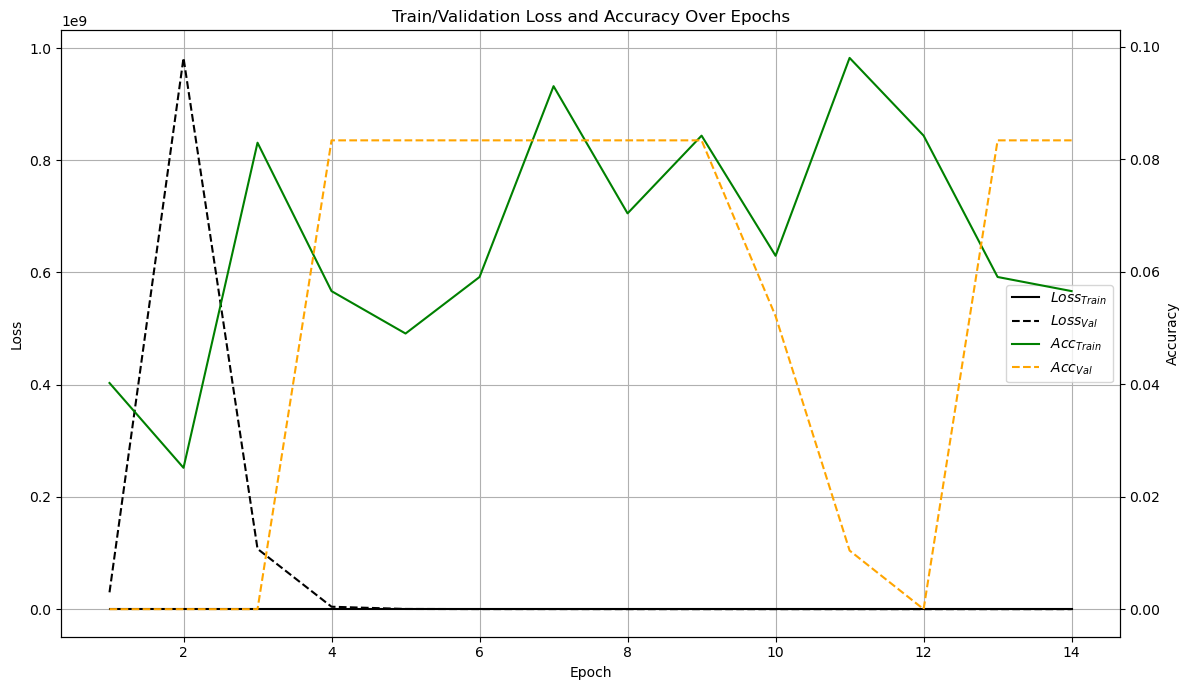

📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1/train_loss_and_accuracy_per_epoch_plot.pdf


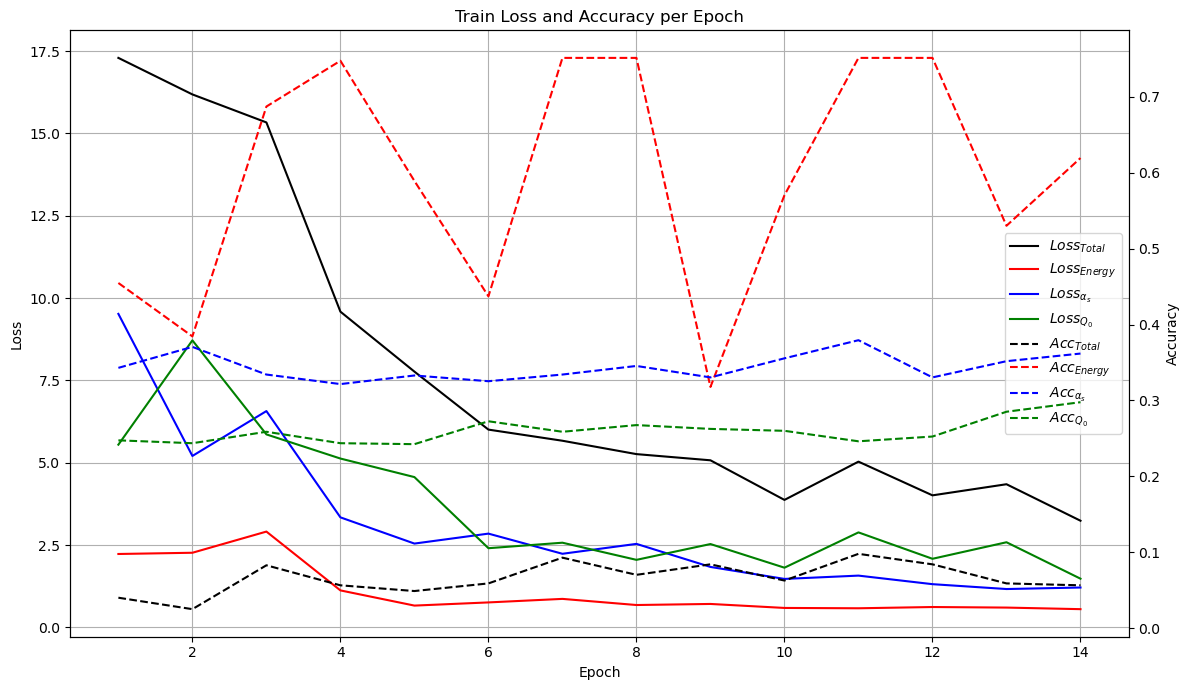

📉 Loss plot saved as:
  - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/EfficientNet_bs512_ep50_lr1e-01_ds1000_g1/validation_loss_and_accuracy_per_epoch_plot.pdf


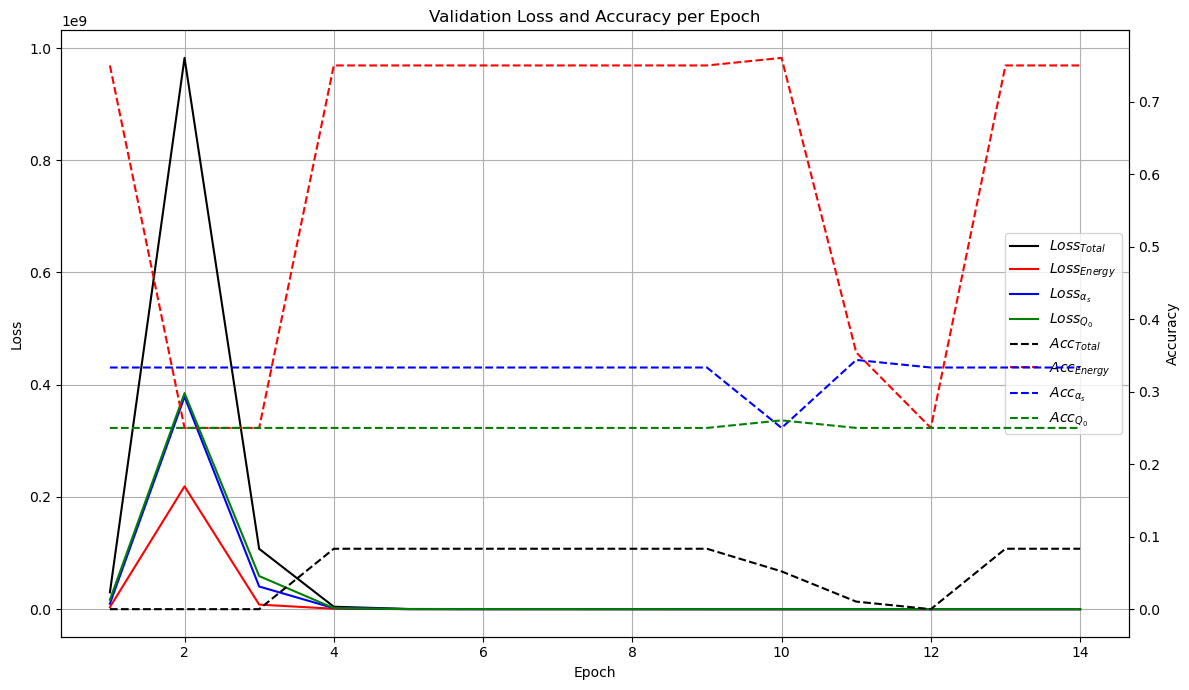

In [15]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")